In [22]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH
import ETFunctions as et
import MathsUtilities as MUte
import math

## Bring in the data needed

In [23]:
WheatBiomass = pd.concat([pd.read_excel('./Wheat/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Wheat'],names=['Crop'])
BarleyBiomass = pd.concat([pd.read_excel('./Barley/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Barley'],names=['Crop'])
OatsBiomass = pd.concat([pd.read_excel('./Oats/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Oats'],names=['Crop'])
FodderBeet = pd.concat([pd.read_excel('./FodderBeet/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['FodderBeet'],names=['Crop'])
LucerneAndPasture = pd.read_excel('./LucerneAndPasture/RawDatafiles/Biomass.xlsx',header=[0,1,2])
SpecLab = LucerneAndPasture.columns.get_level_values(0)
IrriLab = LucerneAndPasture.columns.get_level_values(1)
BlocLab = LucerneAndPasture.columns.get_level_values(2)
NewCols = pd.MultiIndex.from_arrays([SpecLab,
                                     SpecLab,
                                     IrriLab,
                                     SpecLab,
                                     BlocLab], names=['Species','Crop','Irrigation','Nitrogen','Block'])
LucerneAndPasture.columns = NewCols
RyegrassBiomass = LucerneAndPasture.Ryegrass.copy().cumsum()
LucerneBiomass = LucerneAndPasture.Lucerne.copy().cumsum()
Biomass = pd.concat([WheatBiomass,BarleyBiomass,OatsBiomass,FodderBeet,LucerneBiomass,RyegrassBiomass],axis=1)

In [24]:
MetData = pd.read_pickle('BroadFieldsMet.pkl')
DaylightIndex = MetData.IncomingRadnMJ.where(MetData.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()
MetData.loc[:,'satVP'] = [et.saturated_vapor_pressure(MetData.loc[x,'AirTemperature'])/10 for x in MetData.index]
MetData.loc[:,'VP'] = [MetData.loc[x,'satVP']*MetData.loc[x,'RelativeHumidity']/100 for x in MetData.index]
MetData.loc[:,'VPD'] = MetData.satVP.subtract(MetData.VP)

DailyMet = MetData.IncomingRadnMJ.resample('D').sum()
DailyMet = pd.DataFrame(index=DailyMet.index,data=DailyMet.values,columns=['Radn'])
DailyMet.loc[:,'Temp'] = MetData.AirTemperature.resample('D').mean()
DailyMet.loc[:,'RH'] = MetData.RelativeHumidity.resample('D').mean()
DailyMet.loc[:,'PET'] = [et.Priestly_TaylorEO(DailyMet.loc[x,'Radn'],
                                    DailyMet.loc[x,'Temp'],
                                    1.3,'Total') for x in DailyMet.index]
DailyMet.loc[:,'VPD'] = MetData.loc[DaylightIndex,'VPD'].resample('D').mean()
MinVPD = 0.1
DailyMet.loc[:,'VPD'] = DailyMet.loc[:,'VPD'].where(DailyMet.loc[:,'VPD']>MinVPD,MinVPD)
AccumPET = DailyMet.PET.cumsum()

In [25]:
def CleanWUData(DataToClean):
    upperRatio = 1.5
    lowerRatio = 0.01
    WURatio = DataToClean.copy()
    for row in WURatio.index:
        WURatio.loc[row,:] = np.divide(WURatio.loc[row,:].values,
                                      -1*PET.loc[row].values)
    CleanData = DataToClean.copy()
    CleanData.where(WURatio<upperRatio,np.nan,inplace=True)
    CleanData.where(WURatio>lowerRatio,np.nan,inplace=True)
    WURatio.where(WURatio<upperRatio,np.nan,inplace=True)
    WURatio.where(WURatio>lowerRatio,np.nan,inplace=True)
    WURatio.fillna(method='backfill',inplace=True)
    EstimatedData = WURatio.copy()
    for row in EstimatedData.index:
        EstimatedData.loc[row,:] = np.multiply(WURatio.loc[row,:].values,
                                      -1*PET.loc[row].values)
    
    for col in CleanData.columns:
        for row in CleanData.index:
            if math.isnan(CleanData.loc[row,col]):
                CleanData.loc[row,col] = EstimatedData.loc[row,col]
    return(CleanData)

In [26]:
#Bring in potential Evapotranspiration data from Broadfields station
PET = pd.read_pickle('.\BroadFieldsPET.pkl')

In [27]:
#Bring in soil water use data.
LucWU = pd.read_pickle('.\LucerneAndPasture\DataFrames\LucEstDailyWU.pkl')
LucWU = CleanWUData(LucWU)

RyeWU = pd.read_pickle('.\LucerneAndPasture\DataFrames\RyeEstDailyWU.pkl')
RyeWU = CleanWUData(RyeWU)

WheatDaylightIndex = np.load('.\Wheat\DataFrames\DaylightIndex.npy')
WheatHourlyWU = pd.read_pickle('.\Wheat\DataFrames\HourlyWUmm.pkl')
WheatWU = pd.concat([WheatHourlyWU.reindex(WheatDaylightIndex).resample('d').sum()],axis=1,keys=['Wheat'],names=['Crop'])
WheatWU = CleanWUData(WheatWU)

FodderBeetDaylightIndex = np.load('.\FodderBeet\DataFrames\DaylightIndex.npy')
FodderBeetHourlyWU = pd.read_pickle('.\FodderBeet\DataFrames\HourlyWUmm.pkl')
FodderBeetWU = pd.concat([FodderBeetHourlyWU.reindex(FodderBeetDaylightIndex).resample('d').sum()],axis=1,keys=['FodderBeet'],names=['Crop'])
FodderBeetWU = CleanWUData(FodderBeetWU)

OatsDaylightIndex = np.load('.\Oats\DataFrames\DaylightIndex.npy')
OatsHourlyWU = pd.read_pickle('.\Oats\DataFrames\HourlyWUmm.pkl')
OatsWU = pd.concat([OatsHourlyWU.reindex(OatsDaylightIndex).resample('d').sum()],axis=1,keys=['Oats'],names=['Crop'])
OatsWU = CleanWUData(OatsWU)

BarleyDaylightIndex = np.load('.\Barley\DataFrames\DaylightIndex.npy')
BarleyHourlyWU = pd.read_pickle('.\Barley\DataFrames\HourlyWUmm.pkl') 
BarleyWU = pd.concat([BarleyHourlyWU.reindex(BarleyDaylightIndex).resample('d').sum()],axis=1,keys=['Barley'],names=['Crop'])
BarleyWU = CleanWUData(BarleyWU)

WU = pd.concat([WheatWU,FodderBeetWU,LucWU,RyeWU,OatsWU,BarleyWU],axis=1)
WU.dropna(how='all',inplace=True)
GH.SortFrame(WU)

In [28]:
CommonDates = list(set(Biomass.index).intersection(WU.index))
CommonDates.sort()

In [29]:
WU = WU.loc[np.min(CommonDates):,:].dropna(how='all').copy()
AccumulatedWU = WU.cumsum(axis=0).copy() * -1
WUoverVPD = WU.divide(DailyMet.loc[WU.index,'VPD'],axis=0)
AccumWUoverVPD = WUoverVPD.cumsum(axis=0).copy() * -1

In [30]:
SetDate1 = '2012-07-01'
SetDate2 = '2013-07-01'
StartDate2 = '2013-07-02'
FinalDate = '2014-07-01'
AccumSet1 = AccumulatedWU.loc[SetDate1,:].copy()
AccumSet2 = AccumulatedWU.loc[SetDate2,:].copy()
AccumulatedWU.loc[SetDate1:SetDate2,'Lucerne'] = AccumulatedWU.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
AccumulatedWU.loc[StartDate2:FinalDate,'Lucerne'] = AccumulatedWU.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
AccumulatedWU.loc[SetDate1:SetDate2,'Ryegrass'] = AccumulatedWU.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
AccumulatedWU.loc[StartDate2:FinalDate,'Ryegrass'] = AccumulatedWU.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values

AccumSet1 = AccumWUoverVPD.loc[SetDate1,:].copy()
AccumSet2 = AccumWUoverVPD.loc[SetDate2,:].copy()
AccumWUoverVPD.loc[SetDate1:SetDate2,'Lucerne'] = AccumWUoverVPD.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
AccumWUoverVPD.loc[StartDate2:FinalDate,'Lucerne'] = AccumWUoverVPD.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
AccumWUoverVPD.loc[SetDate1:SetDate2,'Ryegrass'] = AccumWUoverVPD.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
AccumWUoverVPD.loc[StartDate2:FinalDate,'Ryegrass'] = AccumWUoverVPD.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values

AccumSet1 = Biomass.loc[SetDate1,:].copy()
AccumSet2 = Biomass.loc[SetDate2,:].copy()
Biomass.loc[SetDate1:SetDate2,'Lucerne'] = Biomass.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
Biomass.loc[StartDate2:FinalDate,'Lucerne'] = Biomass.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
Biomass.loc[SetDate1:SetDate2,'Ryegrass'] = Biomass.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
Biomass.loc[StartDate2:FinalDate,'Ryegrass'] = Biomass.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values


In [31]:
Crops = Biomass.columns.get_level_values(0).drop_duplicates().values
WheatGPs = GH.SetGraphicsPatterns(Biomass.Wheat.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

FodderBeetGPs = GH.SetGraphicsPatterns(Biomass.FodderBeet.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

LucerneGPs = GH.SetGraphicsPatterns(Biomass.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)

RyegrassGPs = GH.SetGraphicsPatterns(Biomass.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)

OatsGPs = GH.SetGraphicsPatterns(Biomass.Oats.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['purple','green','orange'])
BarleyGPs = GH.SetGraphicsPatterns(Biomass.Barley.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '50', '250']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 2, 1, 0, 2, 1]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          50    -   green  0.15   o   green
          250   -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          50   --   green  0.45   ^   white
          250  --  purple  0.45   ^   white
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '50', '300']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '300', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 2, 1, 0, 2, 1]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'ora

In [32]:
def MakeTimeSeriesGraphs(Data,name,ymin,ymax=None):
    Graph = plt.figure(figsize=(18,30))
    Crops = Data.columns.get_level_values(0).drop_duplicates().values
    pos = 1
    for C in Crops:
        GP = globals()[C+'GPs']
        ax = Graph.add_subplot(3,2,pos)
        plt.title(C, fontsize=28)
        GH.AddIndexedPlot(Data.reindex(CommonDates).loc[:,C].dropna(how='all'),ax,GP,2)
        plt.ylabel(name, fontsize=36);
        plt.ylim(ymin,ymax)
        plt.tick_params(labelsize=20)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=int(np.ceil(Data.loc[:,C].dropna(how='all').index.size/30/5))))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
        GH.AddLegend(1,16,'')
        pos+=1
def MakeSingleCropTimeSeries(Data,Crop):
    graph = plt.figure(figsize=(18,18))
    ax = graph.add_subplot(1,1,1)
    GP = globals()[Crop+'GPs']
    GH.AddIndexedPlot(Data.reindex(CommonDates).loc[:,Crop].dropna(how='all'),ax,GP,2)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


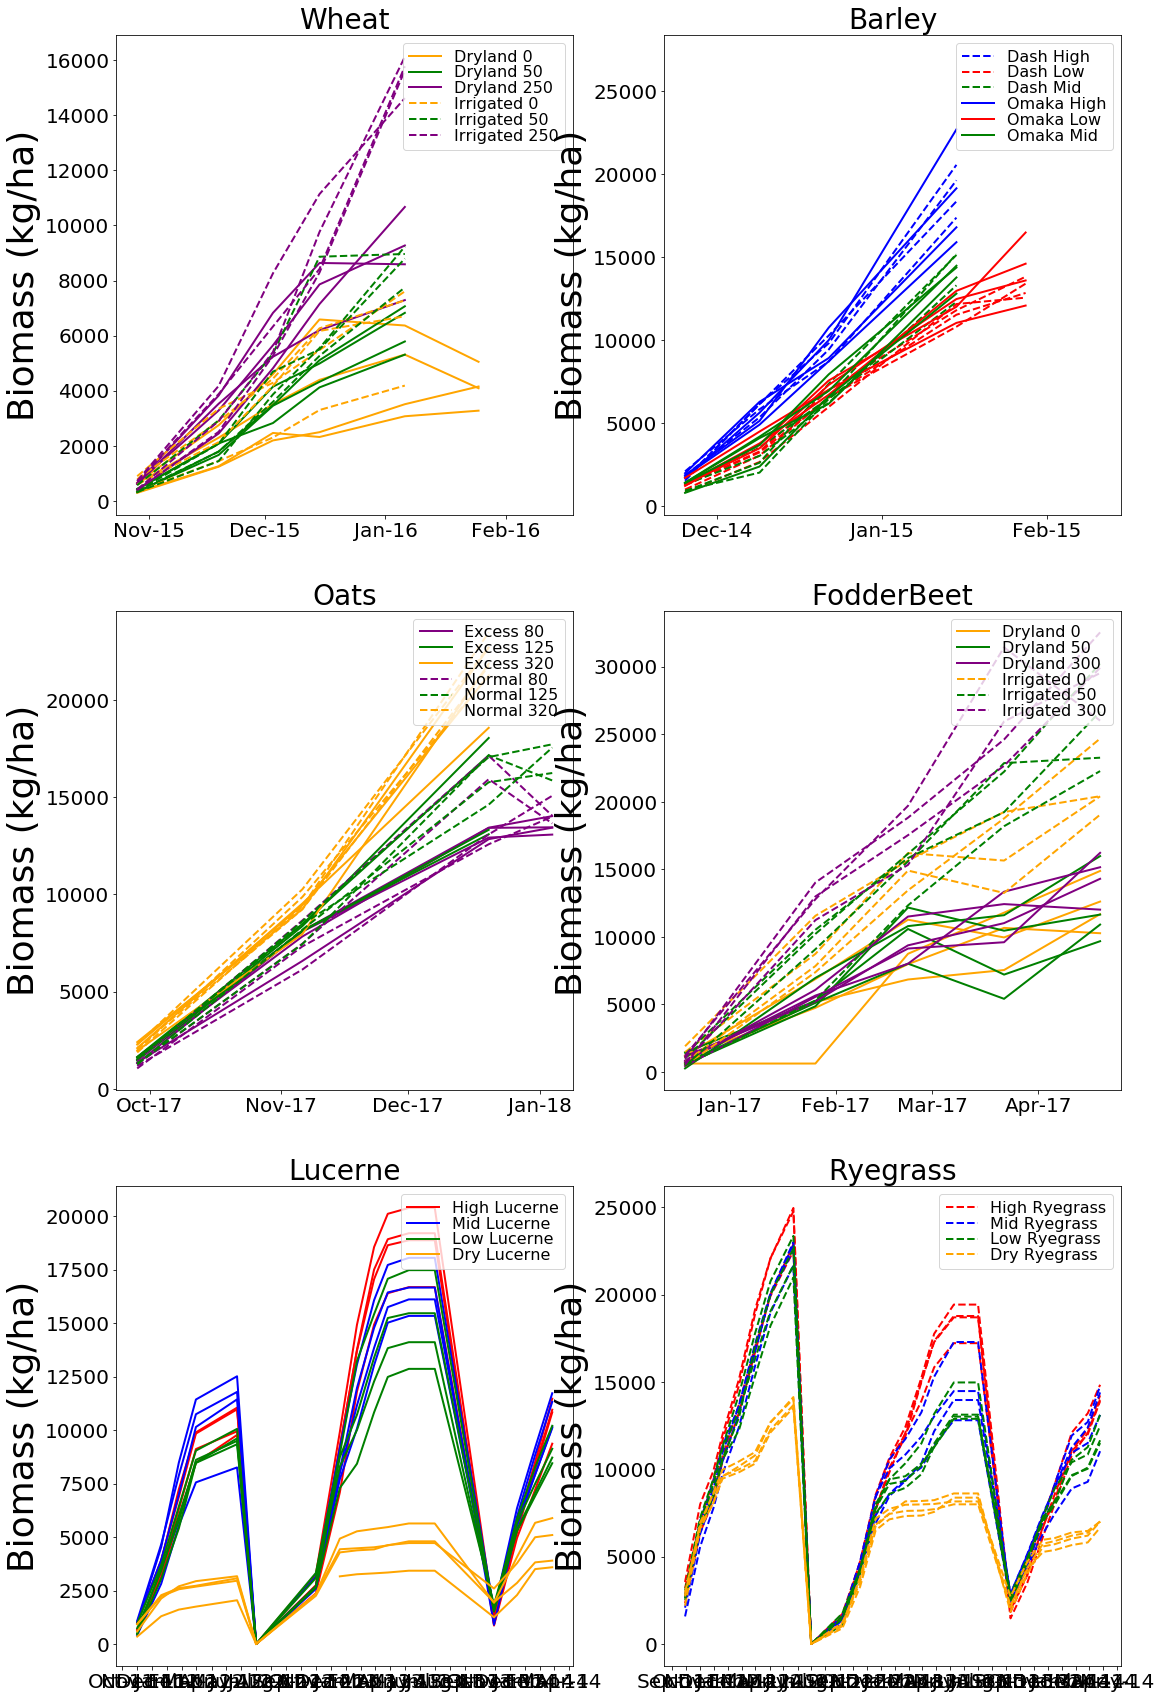

In [33]:
MakeTimeSeriesGraphs(Biomass,'Biomass (kg/ha)',None,)

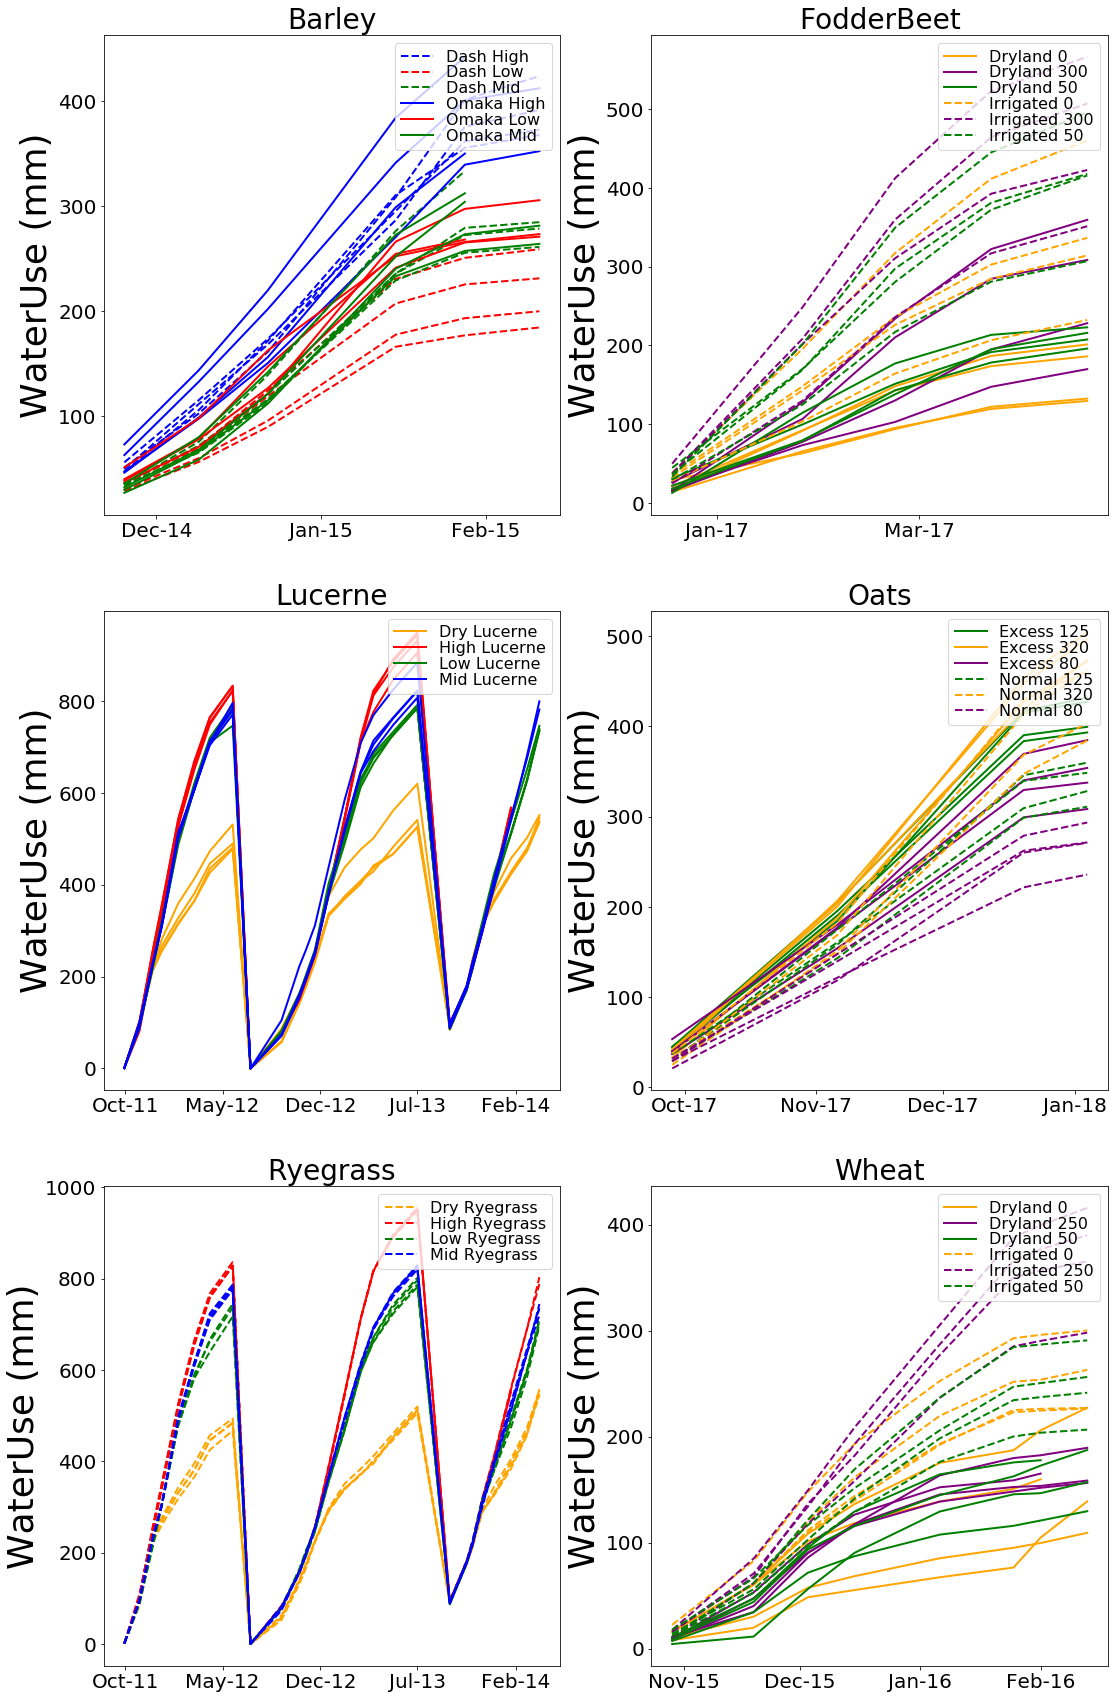

In [34]:
MakeTimeSeriesGraphs(AccumulatedWU,'WaterUse (mm)',None,)

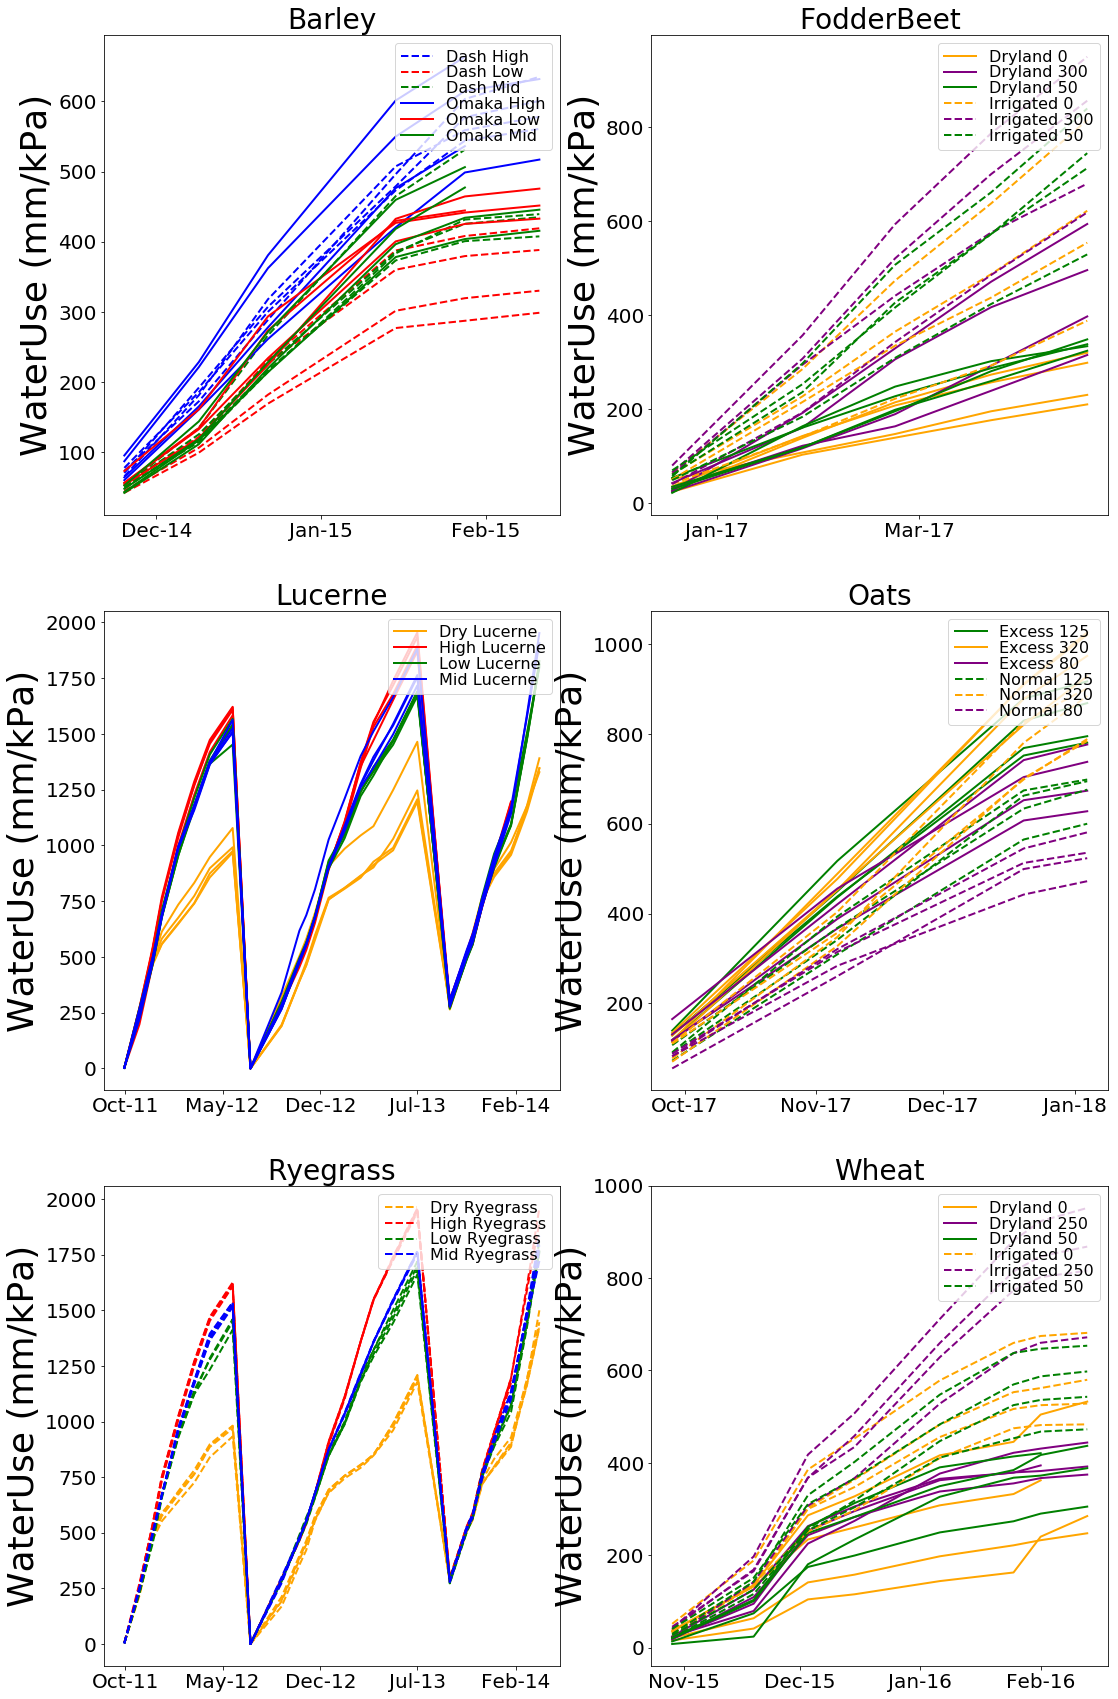

In [35]:
MakeTimeSeriesGraphs(AccumWUoverVPD,'WaterUse (mm/kPa)',None,)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


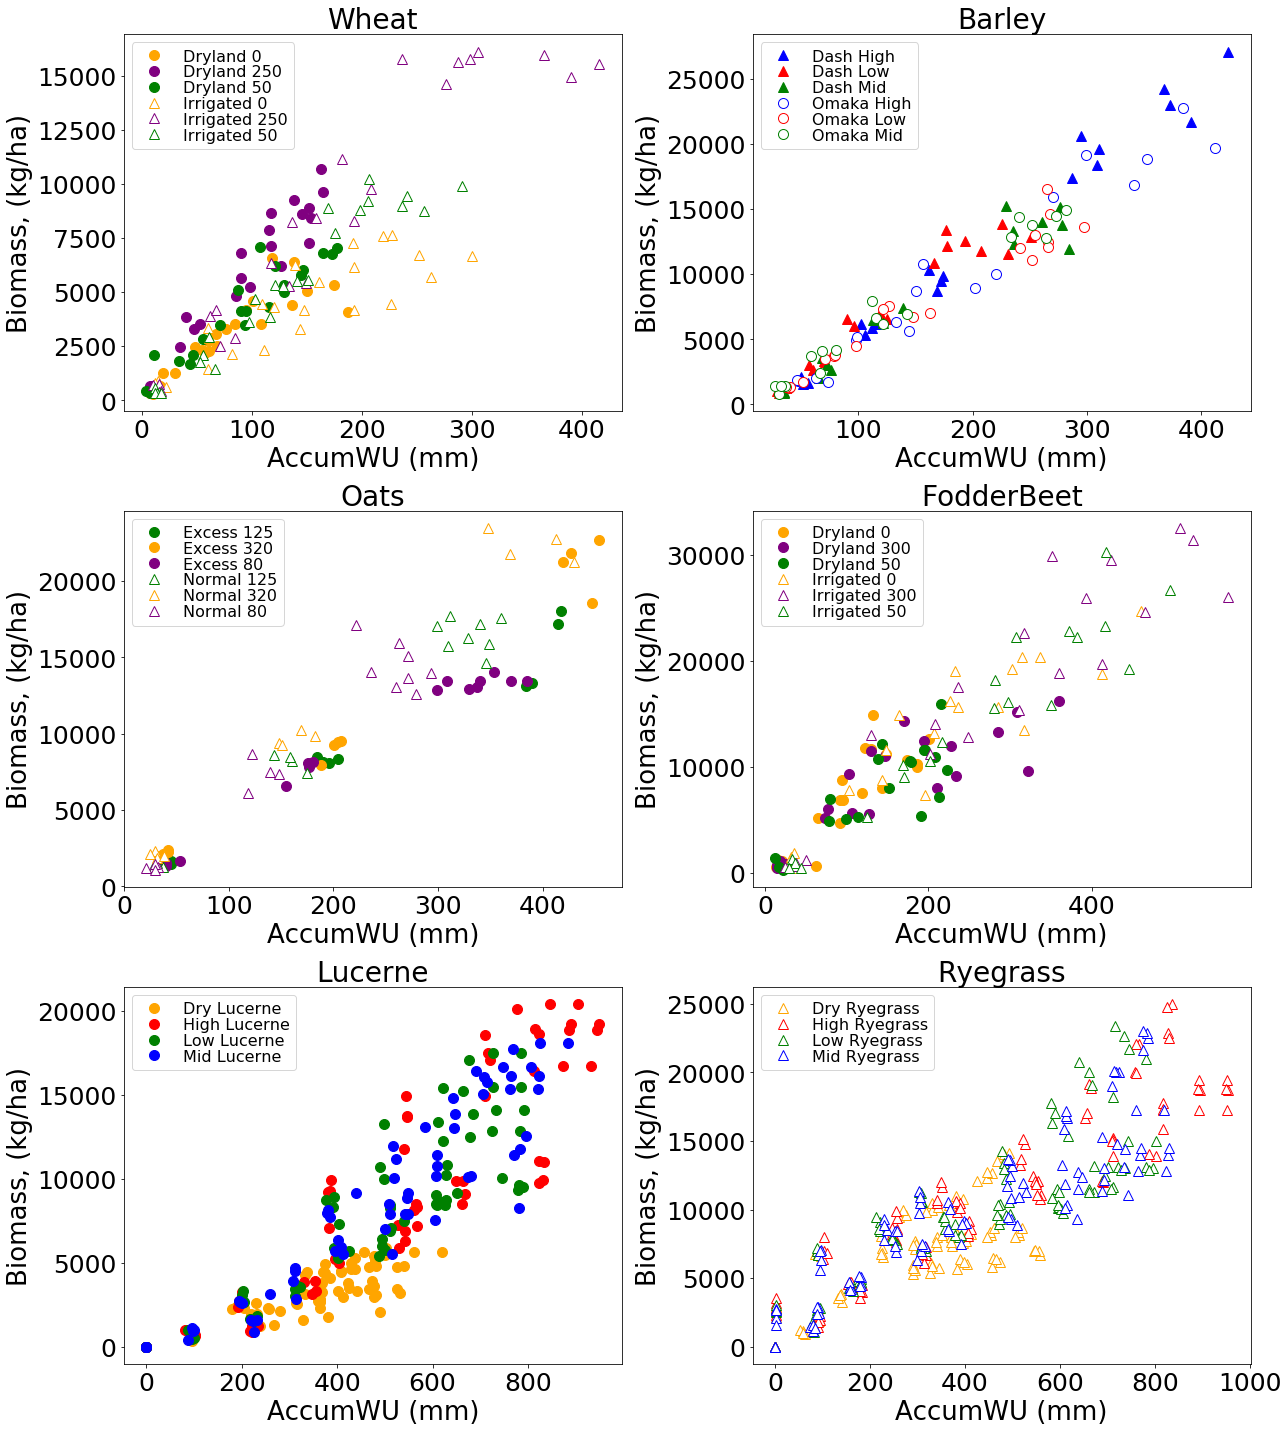

In [36]:
Graph = plt.figure(figsize=(18,20))
pos =  1
for crop in Crops:
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedXY(AccumulatedWU.reindex(Biomass.index).loc[:,crop],
                        Biomass.loc[:,crop],
                        ax,globals()[crop+'GPs'], 10)
        GH.SetAxProps(crop,30,'Biomass, (kg/ha)','AccumWU (mm)',26,25)
        GH.AddLegend(2,16,"")
        plt.title(crop, fontsize=28)
#         Y = MeanPeriodE.loc[:,crop].stack().stack().stack()
#         X = -1 * WU.loc[:,crop].stack().stack().stack().reindex(Y.index)
#         RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
#         Xs = []
#         Xs.append(X.min())
#         Xs.append(X.max())
#         Ys = []
#         Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
#         Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#         plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
#         fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#             + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
#             + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
#             + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
#         plt.text(.7,.05,fitR2,fontsize=16,transform=ax.transAxes)
        pos +=1
plt.tight_layout()   

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


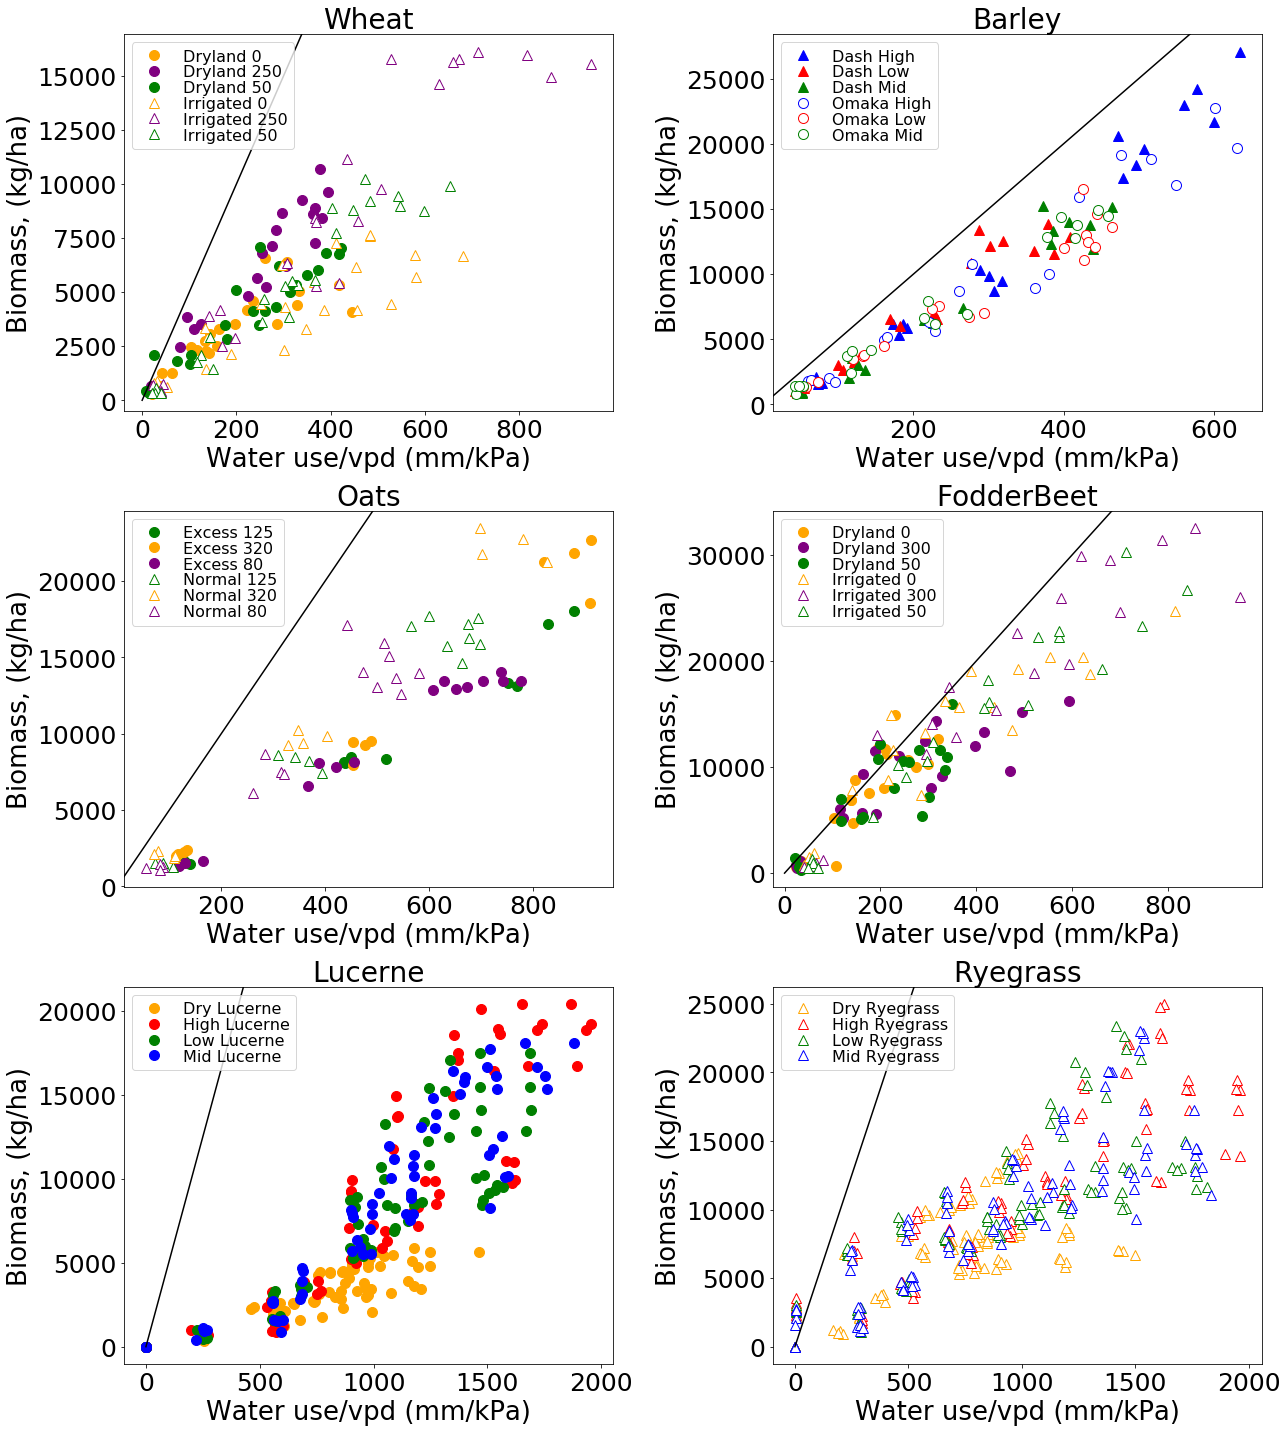

In [37]:
Graph = plt.figure(figsize=(18,20))
pos =  1
for crop in Crops:
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedXY(AccumWUoverVPD.reindex(Biomass.index).loc[:,crop],
                        Biomass.loc[:,crop],
                        ax,globals()[crop+'GPs'], 10)
        GH.SetAxProps(crop,30,'Biomass, (kg/ha)','Water use/vpd (mm/kPa)',26,25)
        GH.AddLegend(2,16,"")
        plt.title(crop, fontsize=28)
        plt.plot([0,1500],[0,75000],'-k')
#         Y = MeanPeriodE.loc[:,crop].stack().stack().stack()
#         X = -1 * WU.loc[:,crop].stack().stack().stack().reindex(Y.index)
#         RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
#         Xs = []
#         Xs.append(X.min())
#         Xs.append(X.max())
#         Ys = []
#         Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
#         Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#         plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
#         fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#             + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
#             + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
#             + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
#         plt.text(.7,.05,fitR2,fontsize=16,transform=ax.transAxes)
        pos +=1
plt.tight_layout()   